# Lab 7: Exercise solutions

In [1]:
with open('../course/common.py') as fin:
    exec(fin.read())

In [2]:
with open('../course/matplotlibconf.py') as fin:
    exec(fin.read())

## Exercise 1

Your manager at the power company is quite satisfied with the work you've done predicting the electric load of the next hour and would like to push it further. He is curious to know if your model can predict the load on the next day or even the next week instead of the next hour.

- Go ahead and use the helper function `create_lagged_Xy_win` we created above to generate new `X` and `y` pairs where the `start_lag` is 36 hours or even further. You may want to extend the window size to a little longer than a day.
- Train your best model on this data. You may have to use more than one layer. In which case, remember to use the `return_sequences=True` argument in all layers except for the last one so that they pass sequences to one another.
- Check the goodness of your model by comparing it with test data as well as looking at the $R^2$ score.

In [3]:
df = pd.read_csv('../data/ZonalDemands_2003-2016.csv.bz2',
                 compression='bz2',
                 engine='python')

In [4]:
def combine_date_hour(row):
    date = pd.to_datetime(row['Date'])
    hour = pd.Timedelta("%d hours" % row['Hour'])
    return date + hour

idx = df.apply(combine_date_hour, axis=1)
df = df.set_index(idx)

In [5]:
split_date = pd.Timestamp('01-01-2014')
train = df.loc[:split_date, ['Total Ontario']].copy()
test = df.loc[split_date:, ['Total Ontario']].copy()

In [6]:
offset = 10000
scale = 5000

train_sc = (train - offset) / scale
test_sc = (test - offset) / scale

In [7]:
def create_lagged_Xy_win(data, start_lag=1,
                         window_len=1):
    X = data.shift(start_lag + window_len - 1).copy()
    X.columns = ['T_{}'.format(start_lag + window_len - 1)]

    if window_len > 1:
        for s in range(window_len, 0, -1):
            col_ = 'T_{}'.format(start_lag + s - 1)
            X[col_] = data.shift(start_lag + s - 1)

    X = X.dropna()
    idx = X.index
    y = data.loc[idx]
    return X, y

In [8]:
start_lag=36
window_len=72

X_train, y_train = create_lagged_Xy_win(
    train_sc, start_lag, window_len)

X_test, y_test = create_lagged_Xy_win(
    test_sc, start_lag, window_len)

In [9]:
X_train_t = X_train.values.reshape(-1, window_len, 1)
X_test_t = X_test.values.reshape(-1, window_len, 1)

y_train_t = y_train.values
y_test_t = y_test.values

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

In [11]:
K.clear_session()

model = Sequential()
model.add(LSTM(12, input_shape=(window_len, 1),
               kernel_initializer='normal',
               return_sequences=True))
model.add(LSTM(6, kernel_initializer='normal'))
model.add(Dense(1))

model.compile(optimizer=Adam(lr=0.05),
              loss='mean_squared_error')

In [12]:
model.fit(X_train_t, y_train_t,
          epochs=5,
          batch_size=256,
          verbose=1);

Epoch 1/5
93445/93445 [==============================] - 5s 53us/sample - loss: 0.2756
Epoch 2/5
93445/93445 [==============================] - 3s 36us/sample - loss: 0.1040
Epoch 3/5
93445/93445 [==============================] - 3s 36us/sample - loss: 0.0856
Epoch 4/5
93445/93445 [==============================] - 3s 36us/sample - loss: 0.0790
Epoch 5/5
93445/93445 [==============================] - 3s 36us/sample - loss: 0.0732


Let's compare the predictions on the test set. We will a few days of data and put vertical bars to mark an interval of 36 hours:

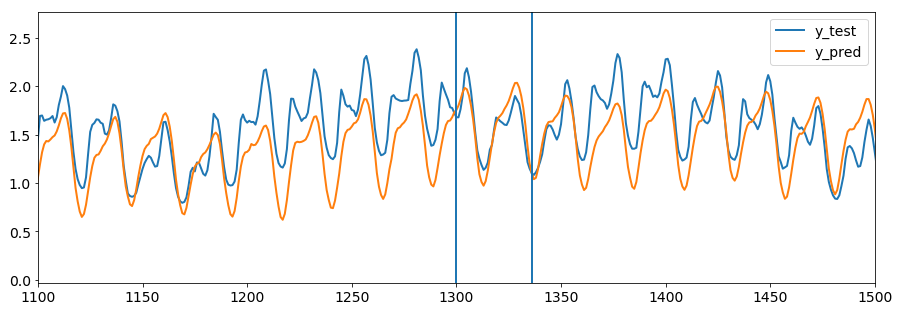

In [13]:
y_pred = model.predict(X_test_t, batch_size=256)
plt.figure(figsize=(15,5))
plt.plot(y_test_t, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.xlim(1100,1500)
plt.axvline(1300)
plt.axvline(1336);

## Exercise 2

[Gate Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) (GRU) are a more modern and simpler implementation of a cell that retains longer term memory.

Keras makes them available in `keras.layers.GRU`. Try swapping the LSTM layer with a GRU layer and re-train the model. Does its performance improve on the 36 hours lag task?

In [14]:
from tensorflow.keras.layers import GRU

In [15]:
K.clear_session()

model = Sequential()
model.add(GRU(12, input_shape=(window_len, 1),
              kernel_initializer='normal',
              return_sequences=True))
model.add(GRU(6, kernel_initializer='normal'))
model.add(Dense(1))

model.compile(optimizer=Adam(lr=0.05),
              loss='mean_squared_error')

In [16]:
model.fit(X_train_t, y_train_t,
          epochs=5,
          batch_size=256,
          verbose=1);

Epoch 1/5
93445/93445 [==============================] - 4s 40us/sample - loss: 0.1505
Epoch 2/5
93445/93445 [==============================] - 3s 37us/sample - loss: 0.0704
Epoch 3/5
93445/93445 [==============================] - 3s 37us/sample - loss: 0.0662
Epoch 4/5
93445/93445 [==============================] - 3s 37us/sample - loss: 0.0597
Epoch 5/5
93445/93445 [==============================] - 3s 37us/sample - loss: 0.0562


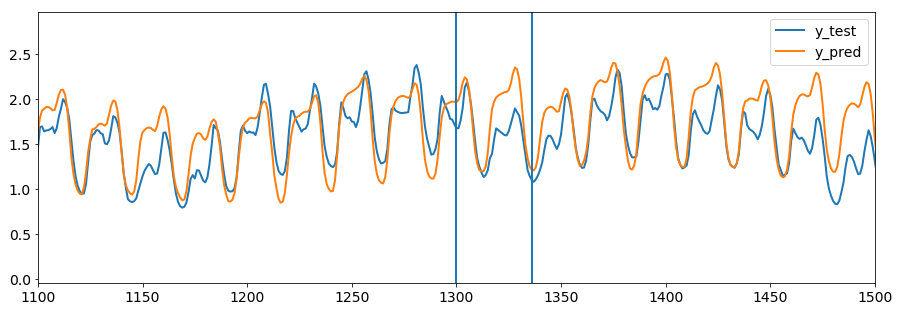

In [17]:
y_pred = model.predict(X_test_t, batch_size=256)
plt.figure(figsize=(15,5))
plt.plot(y_test_t, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.xlim(1100,1500)
plt.axvline(1300)
plt.axvline(1336);

GRU not only trains faster, but also seems to reach a better performance than LSTM on this task.

## Exercise 3

Does a fully connected model work well using Windows? Let's find out! Try to train a fully connected model on the lagged data with Windows, which will probably train much faster:

- reshape the input data back to an Order-2 tensor, i.e., eliminate the 3rd axis
- build a fully connected model with one or more layers
- train the fully connected model on the windowed data. Does it work well? Is it faster to train?

In [18]:
X_train = X_train_t.squeeze()
X_test = X_test_t.squeeze()

In [19]:
model = Sequential()

model.add(Dense(24, input_dim=window_len, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train_t,
          epochs=50,
          batch_size=256,
          verbose=0);

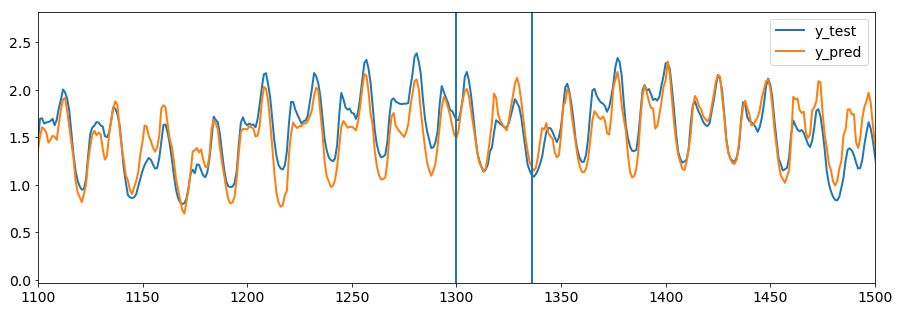

In [21]:
y_pred = model.predict(X_test, batch_size=256)
plt.figure(figsize=(15,5))
plt.plot(y_test_t, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.xlim(1100,1500)
plt.axvline(1300)
plt.axvline(1336);

## Exercise 4

> Disclaimer: past performance is no guarantee of future results. This is not investment advice.

Predicting the price of Bitcoin from historical data.

You may have heard people talk about Bitcoin and how it is growing that you decide to put your newly acquired Deep Learning skills to test in trying to beat the market. The idea is simple: if we could predict what Bitcoin is going to do in the future, we can trade and profit using that knowledge.

The simplest formulation of this forecasting problem is to try to predict if the price of Bitcoin is going to go up or down in the future, i.e., we can frame the issue as a binary classification that answers the question: is Bitcoin going up.

Here are the steps to complete this exercise:

1. Load the data from `../data/poloniex_usdt_btc.json.gz` into a Pandas DataFrame. We obtained this data through the public API of the Poloniex cryptocurrency exchange.
- Check out the data using `df.head()`. Notice that the dataset contains the following columns:
    - `close`: last price (in USD) in a 30 minute interval (candle)
    - `high`: highest price in a 30 minute candle
    - `low`: lowest price in a 30 minute candle
    - `open`: first price in a 30 minute candle
    - `quoteVolume` and `volume`: total amount traded on the exchange
    - `weightedAverage`: this will be our outcome variable
- Convert the date column to a datetime object using `pd.to_datetime` and set it as the index of the DataFrame.
- Plot the value of `df['close']` to inspect the data. You will notice that it's not periodic at all and it has an overall enormous upward trend, so we will need to transform the data into a stationary time series. We will use percentage changes, i.e., we will look at relative movements in the price instead of absolute values.
- Create a new dataset `df_percent` with percent changes using the formula: 
\begin{equation}
v_t = 100 \times \frac{x_t - x_{t-1}}{x_{t-1}}
\end{equation}
this is what we will use next.
- Inspect `df_percent` and notice that it contains both infinity and nan values. Drop the null values and replace the infinity values with zero.
- Split the data on January 1st, 2017, using the data before then as training and the data after that as the test.
- Use the window method to create an input training tensor `X_train_t` with the shape (n_windows, window_len, n_features). This is the main part of the exercise since you'll have to make a few choices and be careful not to leak information from the future. In particular, you will have to:
    - decide the window_len you want to use
    - decide which features you'd like to use as input (don't use `weightedAverage`, since we'll need it for the output.
    - decide what lag you want to introduce between the last timestep in your input window and the timestep of the output.
    - You can start from the `create_lagged_Xy_win` function we defined in Lab 7, but you will have to modify it to work with numpy arrays because Pandas DataFrames are only good with one feature.
- Create a binary outcome variable corresponding to `df_percent_train[weightedAverage] >= 0`. This variable is going to be our label and do the same thing for the test set.
- Create a model to work with this data. Make sure the input layer has the right `input_shape` and the output layer has one node with a Sigmoid activation function. Also, make sure to use the `binary_crossentropy` loss and to track the accuracy of the model.
- Train the model on the training data
- Test the model on the test data. Is the accuracy better than a baseline guess? Are you going to be rich?

> Again disclaimer: past performance is no guarantee of future results. This is not investment advice.

In [22]:
df = pd.read_json('../data/poloniex_usdt_btc.json.gz',
                  compression='gzip')

In [23]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

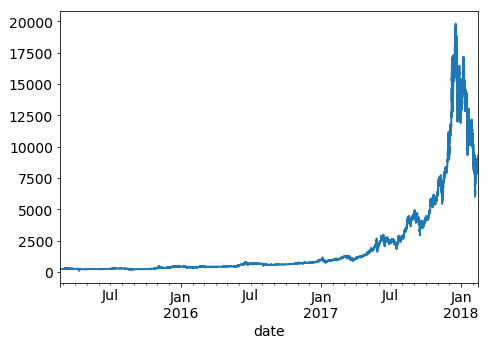

In [24]:
df['close'].plot();

In [25]:
df_percent = ((df - df.shift()) / df.shift()) * 100.0

In [26]:
df_percent.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-02-19 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-19 19:30:00,0.000000,0.000000,0.000000,0.000000,-100.000000,-100.000000,0.000000
2015-02-19 20:00:00,6.666667,6.666667,0.000000,0.000000,inf,inf,5.818701
2015-02-19 20:30:00,1.666667,1.666667,8.444444,8.444444,-53.317086,-52.158715,2.481361
2015-02-19 21:00:00,0.000000,0.000000,0.000000,0.000000,-100.000000,-100.000000,0.000000


In [27]:
df_percent = df_percent.dropna()\
                 .replace(-np.inf, 0)\
                 .replace(np.inf, 0)
df_percent['y'] = df_percent['weightedAverage'] >= 0

In [28]:
split_date = pd.Timestamp('01-01-2017')
train = df_percent.loc[:split_date].copy()
test = df_percent.loc[split_date:].copy()

In [29]:
def create_lagged_Xy_win_t(data, start_lag=1,
                           window_len=1):
    
    X = data[['close', 'high', 'low', 'open']].copy()
    y = data['y']
    
    rows, columns = X.shape
    shape_ = (rows - window_len - 1, window_len, columns)
    X_t = np.zeros(shape_)
    y_t = y.values[window_len + 1:]

    if window_len > 1:
        for s in range(window_len, 0, -1):
            all_values = X.shift(start_lag + s - 1).values
            X_t[:, window_len - s, :] = all_values[window_len + 1:]
    
    return X_t, y_t

In [30]:
start_lag = 1
window_len = 36

In [31]:
X_train_t, y_train_t = create_lagged_Xy_win_t(
    train, start_lag, window_len)

X_test_t, y_test_t = create_lagged_Xy_win_t(
    test, start_lag, window_len)

In [32]:
train.head(10)

,close,high,low,open,quoteVolume,volume,weightedAverage,y
date,,,,,,,,
2015-02-19 19:30:00,0.000000,0.000000,0.000000,0.000000,-100.000000,-100.000000,0.000000e+00,True
2015-02-19 20:00:00,6.666667,6.666667,0.000000,0.000000,0.000000,0.000000,5.818701e+00,True
2015-02-19 20:30:00,1.666667,1.666667,8.444444,8.444444,-53.317086,-52.158715,2.481361e+00,True
2015-02-19 21:00:00,0.000000,0.000000,0.000000,0.000000,-100.000000,-100.000000,0.000000e+00,True
2015-02-19 22:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,True
2015-02-19 23:00:00,0.000000,0.000000,0.000000,0.000000,-100.000000,-100.000000,0.000000e+00,True
2015-02-20 06:00:00,-1.536838,-1.536837,-1.536838,-1.536837,0.000000,0.000000,-1.536838e+00,False
2015-02-20 06:30:00,0.000000,-0.000001,0.000000,-0.000001,-100.000000,-100.000000,-4.162332e-09,False
2015-02-20 08:30:00,1.977058,1.977058,1.560825,1.560825,0.000000,0.000000,1.909331e+00,True


In [33]:
X_train_t.shape

(23956, 36, 4)

In [34]:
y_train_t.shape

(23956,)

In [35]:
K.clear_session()

model = Sequential()
model.add(GRU(24, input_shape=(window_len, 4),
              kernel_initializer='normal',
              return_sequences=True))
model.add(GRU(18, kernel_initializer='normal',
              return_sequences=True))
model.add(GRU(12, kernel_initializer='normal'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.02),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_gru (UnifiedGRU)     (None, 36, 24)            2160      
_________________________________________________________________
unified_gru_1 (UnifiedGRU)   (None, 36, 18)            2376      
_________________________________________________________________
unified_gru_2 (UnifiedGRU)   (None, 12)                1152      
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 5,701
Trainable params: 5,701
Non-trainable params: 0
_________________________________________________________________


In [37]:
h = model.fit(X_train_t, y_train_t,
              epochs=20,
              batch_size=512,
              validation_split=0.1,
              verbose=1);

Train on 21560 samples, validate on 2396 samples
Epoch 1/20
21560/21560 [==============================] - 1s 59us/sample - loss: 0.6703 - accuracy: 0.5821 - val_loss: 0.6770 - val_accuracy: 0.5760
Epoch 2/20
21560/21560 [==============================] - 1s 25us/sample - loss: 0.6545 - accuracy: 0.6128 - val_loss: 0.6726 - val_accuracy: 0.5851
Epoch 3/20
21560/21560 [==============================] - 0s 22us/sample - loss: 0.6502 - accuracy: 0.6171 - val_loss: 0.6738 - val_accuracy: 0.5801
Epoch 4/20
21560/21560 [==============================] - 0s 22us/sample - loss: 0.6467 - accuracy: 0.6222 - val_loss: 0.6723 - val_accuracy: 0.5906
Epoch 5/20
21560/21560 [==============================] - 0s 22us/sample - loss: 0.6473 - accuracy: 0.6236 - val_loss: 0.6726 - val_accuracy: 0.5839
Epoch 6/20
21560/21560 [==============================] - 0s 22us/sample - loss: 0.6422 - accuracy: 0.6276 - val_loss: 0.6730 - val_accuracy: 0.5910
Epoch 7/20
21560/21560 [==============================] -

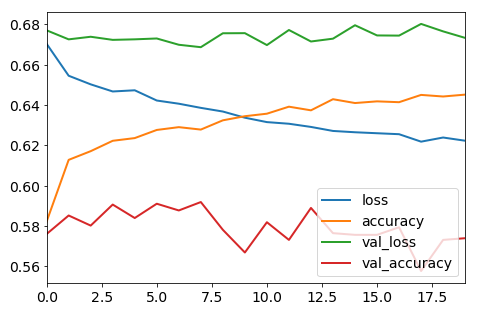

In [38]:
pd.DataFrame(h.history).plot()

In [39]:
model.evaluate(X_train_t, y_train_t)

23956/23956 [==============================] - 2s 104us/sample - loss: 0.6150 - accuracy: 0.6506


[0.614983837051968, 0.6505677]

In [40]:
pd.Series(y_train_t).value_counts() / len(y_test_t)

True     0.675954
False    0.544237
dtype: float64

In [41]:
model.evaluate(X_test_t, y_test_t)

19633/19633 [==============================] - 2s 104us/sample - loss: 0.6401 - accuracy: 0.6482


[0.6401130141288016, 0.6481944]

In [42]:
pd.Series(y_test_t).value_counts() / len(y_test_t)

True     0.527326
False    0.472674
dtype: float64